# GO vs. Keywords for substrates

Up until now, we have been using Uniprot keywords for annotations. In order to get all transmembrane transporters of Sugar, we filter the proteins in the dataset by the keywords "Transmembrane" and "Sugar transport". 

This works most of the time, but sometimes there is a small number of proteins that fulfils these requirements, but does not actually transport the substrate. That could be the case for a "sugar transport" protein that exchanges ATP and ADP, which is in turn used to promote Sugar transport. This means that the protein we are looking at promotes sugar transport, but is not a sugar transporter by itself. We need all proteins in the dataset to be actual sugar transporters, to learn that function from the sequence.

In order to prevent these cases, we could turn to the Gene Ontology. The advantage here is that the "molecular function" GO terms are much more specific. We would not have to filter for multiple keywords, and could instead just filter for "sugar transmembrane transporter activity". The downside could might be a lower number of samples, or lower-quality annotations if we use automatically annotated go terms.

Tasks:

- Implement tree-shaped datastructure for ontologies like GO and ChEMBL (done)
    - This allows us to get all descendants/children for a GO term, automatically
    - In contrast to Keywords, a protein is not annotated with all of its GO terms. If it is annotated with a descendant of "transmembrane transporter activity", such as "sugar transmembrane transporter activity", then it does not have to be annotated with "transmembrane transporter activity".
- Create four annotation datasets:
    - Swissprot GO annotations (filtered and preprocessed by Uniprot)
    - Swissprot annotation from GO website without electronically inferred evidence (IEA) (doing the filtering ourselves)
    - Swissprot annotation from GO website with electronically inferred evidence (IEA) (doing the filtering ourselves)
    - Swissprot keywords
- Statistics for Swissprot
    - How many transmembrane transporters are in each dataset?
    - How many sugar/amino-acid/ion transporters?
- Comparative analysis
    - Venn diagrams
    - What is the size of the intersection/difference sets?
    - Look at samples of transporters that have GO term but not Keyword
- CHEBI substrates from TCDB
    - TCDB lists substrates with chebi identifiers for transport mechanisms. 
    - What is the overlap with the best set from the previous step? 
- Statistics for Swissprot + TrEMBL
    - How many more transporters do we get with each annotation dataset, when we do not filter for Swissprot?

## Information

#### Transmembrane annotations in Uniprot

https://www.uniprot.org/help/transmem

Transmembrane helices in Swissprot are annotated via:

- Prediction tools
- Experimentally determined
- Similarity to protein family that is known to contain TM domains

In TrEMBL, the annotation happens automatically via TMHMM program.

Multi-pass membrane proteinns are annotated as such in "Subcellular location" column, that might also be interesting for filtering. 

Beta-barrels are not predicted by Uniprot, therefore the information might be absent. Beta-barrel property can be found in Domains column.

#### Uniprot GO preprocessing

https://www.uniprot.org/help/complete_go_annotation

- Annotation filtering is applied
    - manual annotation preferred
- Some information is removed
    - with/from column
    - the qualifiers "NOT, contributes_to, colocalizes_with"
    - annotations made to isoform identifiers
- Info on Uniprot is about three months behind QuickGO website

#### What are the differences between UniProtKB keywords and the GO terms?

https://www.uniprot.org/help/keywords_vs_go

- Keywords are manual for Swissprot, and automatic for TrEMBL
- GO terms are manually mapped to keywords and xrefs

#### Gene Ontology (GO) annotations in Uniprot:

https://www.uniprot.org/help/gene_ontology

- Keyword annotations made by Uniprot curators are included in GO with IEA evidence code!
    - Keyword annotations and GO annotations will probably not be the same
    - Swissprot is already annotated by curators, but GO might use more recent research
    - Union set of GO and keywords might increase sample count, especially for TrEMBL

## Creating datasets, genesets, and GO term/keyword sets

Basic filtering is applied in the function: Removing fragmented sequences, and proteins that do not have evidence at either transcript level or protein level, among other things.

In [1]:
from subpred.dataset import (
    create_dataset,
    get_go_df,
    get_keywords_df,
    get_tcdb_substrates,
    parse_columns,
)
from subpred.go_utils import GeneOntology, read_go_uniprot
import pandas as pd

df_swissprot = create_dataset(
    # keywords_classes=["Amino-acid transport", "Sugar transport"],
    # keywords_filter=["Transmembrane", "Transport"],
    input_file="../data/raw/uniprot/uniprot_2022_05_evidence1-2_nofragments.tsv",
    multi_substrate="keep",
    verbose=True,
    # tax_ids_filter=[3702, 9606, 83333, 559292],
    # outliers=outliers,
    # sequence_clustering=70,
    evidence_code=2,
    invalid_amino_acids="remove_protein",
    # force_update=True,
    tcdb_substrates_file="../data/raw/tcdb/tcdb_substrates.tsv",
    swissprot_only=True,
)


Found pickle, reading...


In [2]:
df_swissprot.head()


,gene_names,protein_names,reviewed,protein_existence,sequence,organism_id,go_ids,keyword_ids,keywords,tcdb_id,interpro,tcdb_class,tcdb_substrates,keywords_substrates,keywords_transport_related,keywords_location
Uniprot,,,,,,,,,,,,,,,,
A0A0C5B5G6,MT-RNR1,Mitochondrial-derived peptide MOTS-c (Mitochon...,reviewed,Evidence at protein level,MRWQEMGYIFYPRKLR,9606,GO:0001649; GO:0003677; GO:0005615; GO:0005634...,KW-0238; KW-0496; KW-0539; KW-0892; KW-1185; K...,DNA-binding;Mitochondrion;Nucleus;Osteogenesis...,NaN,NaN,0.0,NaN,,,
A0A1B0GTW7,CIROP LMLN2,Ciliated left-right organizer metallopeptidase...,reviewed,Evidence at protein level,MLLLLLLLLLLPPLVLRVAASRCLHDETQKSVSLLRPPFSQLPSKS...,9606,GO:0004222; GO:0005737; GO:0006508; GO:0007155...,KW-0025; KW-0225; KW-0325; KW-1056; KW-0378; K...,Alternative splicing;Disease variant;Glycoprot...,NaN,IPR001577;,0.0,NaN,,,
A0JNW5,BLTP3B KIAA0701 SHIP164 UHRF1BP1L,Bridge-like lipid transfer protein family memb...,reviewed,Evidence at protein level,MAGIIKKQILKHLSRFTKNLSPDKINLSTLKGEGELKNLELDEEVL...,9606,GO:0005769; GO:0005829; GO:0034498; GO:0042803...,KW-0025; KW-0175; KW-0963; KW-0967; KW-0597; K...,Alternative splicing;Coiled coil;Cytoplasm;End...,NaN,IPR026728;IPR026854;,0.0,NaN,,,
A0JP26,POTEB3,POTE ankyrin domain family member B3,reviewed,Evidence at protein level,MVAEVCSMPAASAVKKPFDLRSKMGKWCHHRFPCCRGSGKSNMGTS...,9606,NaN,KW-0025; KW-0040; KW-0175; KW-1185; KW-0677,Alternative splicing;ANK repeat;Coiled coil;Re...,NaN,IPR002110;IPR036770;IPR039497;,0.0,NaN,,,
A0PK11,CLRN2,Clarin-2,reviewed,Evidence at protein level,MPGWFKKAWYGLASLLSFSSFILIIVALVVPHWLSGKILCQTGVDL...,9606,GO:0007605; GO:0032421; GO:0060088; GO:0060171...,KW-1003; KW-0966; KW-0209; KW-0225; KW-0325; K...,Cell membrane;Cell projection;Deafness;Disease...,9.A.46.1.2,IPR026748;,9.A,NaN,,,


In [3]:
go = GeneOntology("../data/raw/ontologies/go.owl")


In [4]:
# Cellular Component
cc_terms = {"membrane": "GO:0016020", "plasma membrane": "GO:0005886"}

mf_terms = {
    "transmembrane transporter activity": "GO:0022857",
    "amino acid transmembrane transporter activity": "GO:0015171",
    "carbohydrate transmembrane transporter activity": "GO:0015144",
    "sugar transmembrane transporter activity": "GO:0051119",
    "ion transmembrane transporter activity": "GO:0015075",
}

swissprot_proteins = set(df_swissprot.index.tolist())
amino_acid_descendants = go.get_descendants(
    go.get_identifier("amino acid transmembrane transporter activity")
)
carbohydrate_descendants = go.get_descendants(
    go.get_identifier("carbohydrate transmembrane transporter activity")
)
sugar_descendants = go.get_descendants(
    go.get_identifier("sugar transmembrane transporter activity")
)
ion_descendants = go.get_descendants(
    go.get_identifier("ion transmembrane transporter activity")
)


## Uniprot GO dataset

Get annotated go terms from Uniprot file:

In [5]:
df_sp_go = get_go_df(df_swissprot, go)
df_sp_go.head()


,Uniprot,go_id,go_term
0,A0A0C5B5G6,GO:0001649,osteoblast differentiation
1,A0A0C5B5G6,GO:0003677,DNA binding
2,A0A0C5B5G6,GO:0005615,extracellular space
3,A0A0C5B5G6,GO:0005634,nucleus
4,A0A0C5B5G6,GO:0005739,mitochondrion


In [6]:
# df_sp_go = df_swissprot.go_ids.str.split(";").explode().str.strip().reset_index(drop=False)
# df_sp_go = df_sp_go.rename(columns={"go_ids": "go_id"})
# df_sp_go = df_sp_go.assign(go_term = df_sp_go.go_id.apply(lambda x: go.get_label(x) if x==x else x))
# df_sp_go.head()


GO terms of interest (for now):

Ontology tree data structure that allows us to retrieve children/parents of GO terms, etc.:

How many proteins in the dataset are annotated with "transmembrane transporter activity"?

In [7]:
print(
    "proteins annotated with transmembrane transporter activity:",
    df_sp_go[df_sp_go.go_id == go.get_identifier("transmembrane transporter activity")]
    .Uniprot.unique()
    .shape[0],
)


proteins annotated with transmembrane transporter activity: 1174


1174 is not that much. 

Is every protein that is annotated with a descendant of "transmembrane transporter activity" also annotated with "transmembrane transporter activity"?

In [8]:
tta_descendants = go.get_descendants(
    go.get_identifier("transmembrane transporter activity")
)
print(
    f"There are {len(tta_descendants)} descendant go terms of transmembrane transporter activity"
)

tta_descendants_proteins = df_sp_go[
    df_sp_go.go_id.isin(tta_descendants)
].Uniprot.unique()
print(
    f"Proteins annotated with transmembrane transporter activity or descendant go term: {tta_descendants_proteins.shape[0]}"
)


There are 1024 descendant go terms of transmembrane transporter activity
Proteins annotated with transmembrane transporter activity or descendant go term: 9189


No, that is not the case! We can get 9189 unique proteins by looking at descendants of the term. 

#### Individual substrates excluding descendants

In [9]:
for term, id in mf_terms.items():
    print(term, df_sp_go[df_sp_go.go_id == id].Uniprot.unique().shape[0])


transmembrane transporter activity 1174
amino acid transmembrane transporter activity 183
carbohydrate transmembrane transporter activity 24
sugar transmembrane transporter activity 68
ion transmembrane transporter activity 30


#### Individual Substrates including descendants

In [10]:
for name, go_term_set in [
    ("amino_desc", amino_acid_descendants),
    ("carbo_desc", carbohydrate_descendants),
    ("sugar_desc", sugar_descendants),
    ("ion_desc", ion_descendants),
]:
    print(name, df_sp_go[df_sp_go.go_id.isin(go_term_set)].Uniprot.unique().shape[0])


amino_desc 554
carbo_desc 481
sugar_desc 286
ion_desc 5699


## Official GO dataset (noiea)

Is the Uniprot GO annotation complete? Or can we gain something by reading the official go swissprot annotations from the go website?

To test this, we will read the Uniprot annotation file from the GO website. These GO annotations have not been filtered by Uniprot.

Qualifiers starting with "NOT" and entries for other DBs have already been removed by the function read_go_swissprot. Evidence codes that were electronivally annotated (IEA) are not part of this dataset. 

We should pay attention to the qualifiers column.

In [11]:
df_go = read_go_uniprot("../data/raw/gene_ontology/goa_uniprot_all_noiea.gaf.gz")


What evidence codes are in the dataset? This "noiea" version explicitly does not contain IEA annotations. The downside of the IEA version is the file size: the NOIEA version is 6mb in size, the IEA version is 171GB. It might also be noisier, since most annoatations have not been checked by a curator.

GO evidence code guide: http://geneontology.org/docs/guide-go-evidence-codes/

We have mapped the evidence codes to descriptions, to make it easier to interpret. After reading the explanations, this looks good:

In [12]:
df_go.evidence_description.value_counts()


curator_statement                        129517
computational_analysis                   115756
experimental_evidence                     56587
experimental_evidence_high_throughput      3156
author_statement                           3154
Name: evidence_description, dtype: int64

#### Explanation of qualifiers

Relations in GO: http://geneontology.org/docs/ontology-relations/

The most common relation between go_terms is "is_a", for example "carbohydrate transmembrane transporter activity" "is_a" "transmembrane transporter activity". This term is used within the same sub-ontology, in this case Molecular Function. Other relations are used when switching from one part of the ontology to another, for example the MF "transmembrane transporter activity" is "part_of" the Biological Process "transmembrane transport".

Most common relations between gene products and GO terms (via GO wiki):

- "involved_in": Function of gene product means that it is involved in a biological process
- "enables": Function of gene product explicitly enables the molecular function. This should be the most important category for us.
- "is_active_in": The cellular component where the gene product carries out its function
- "located_in": No documentation found, but presumably relation between gene product and CC
- part_of: Location of gene product, without making statement about activity in that location. Can also be used to relate GO terms to each other, such as CC
- acts_upstream_of_or_within: Experimental Evidence is not sufficient to relate gene products activity to a biological process. Often derived from mutant phenotypes. 
- contributes_to: gene product is a member of a complex that enables a molecular function. We should probably remove those annotations, since we are only interested in the actual channels/carriers.
- colocalizes_with: resolution of assay is not accurate enough to say that gene product is in cellular component. different interpretations of term possible. Should be removed from dataset.
- acts_upstream_of*: Molecular function of gene product has impact on Biological Process that is downstream of gene product. These relations should also be removed from our dataset.


What we should do:

- Keep "enables" for the MF terms, and "is_active_in" for the CC terms.

In [13]:
df_go.qualifier.value_counts()


involved_in                                   121545
enables                                        94792
is_active_in                                   43369
located_in                                     38776
part_of                                         5102
acts_upstream_of_or_within                      3458
contributes_to                                   519
colocalizes_with                                 476
acts_upstream_of                                  67
acts_upstream_of_positive_effect                  28
acts_upstream_of_or_within_positive_effect        22
acts_upstream_of_negative_effect                  15
acts_upstream_of_or_within_negative_effect         1
Name: qualifier, dtype: int64

#### Creating the GO tables:

Filtering the terms by Molecular Function:

In [14]:
df_go_mf = df_go[(df_go.aspect == "F")]
df_go_mf.shape


(95311, 18)

Only keeping the most accurate qualifier ("enables") 

In [15]:
df_go_mf = df_go_mf[df_go_mf.qualifier == "enables"]
df_go_mf.shape


(94792, 18)

This only removes a small percentage of MF-terms!

In [16]:
df_go_mf.head()


,db,db_object_id,db_object_symbol,qualifier,go_id,db_reference,evidence_code,with_or_from,aspect,db_object_name,db_object_synonym,db_object_type,taxon,date,assigned_by,annotation_extension,gene_product_form_id,evidence_description
2,UniProtKB,Q87UX2,blc,enables,GO:0003674,GO_REF:0000015,ND,NaN,F,Outer membrane lipoprotein Blc,blc|PSPTO_5170,protein,taxon:223283,20061207,JCVI,NaN,NaN,curator_statement
4,UniProtKB,C8VDI1,AN11006,enables,GO:0003674,GO_REF:0000015,ND,NaN,F,Uncharacterized protein AN11006,AN11006,protein,taxon:227321,20200401,AspGD,NaN,NaN,curator_statement
11,UniProtKB,Q2GIQ1,omp-1X,enables,GO:0003674,GO_REF:0000015,ND,NaN,F,Omp-1X,omp-1X|APH_1219,protein,taxon:212042,20061212,TIGR,NaN,NaN,curator_statement
14,UniProtKB,Q93AM0,fldI,enables,GO:0008047,PMID:11967068,IDA,NaN,F,(R)-phenyllactate dehydratase activator,fldI,protein,taxon:1509,20130610,UniProt,NaN,NaN,experimental_evidence
16,UniProtKB,G4NEF6,MGG_00119,enables,GO:0003674,GO_REF:0000015,ND,NaN,F,Prothymosin alpha,MGG_00119,protein,taxon:242507,20080211,PAMGO_MGG,NaN,NaN,curator_statement


Finally, filtering the annotations for those of manually curated SwissProt proteins:

In [17]:
df_go_mf = df_go_mf[df_go_mf.db_object_id.isin(swissprot_proteins)]


#### Comparison to Uniprot GO terms

Now we have a GO annotation dataset directly from GO. From the Uniprot annotations, we had 1174 proteins with the "transmembrane transporter activity", and 9103 proteins when including the descendant go terms. How does that compare to our new GO dataset?

In [18]:
df_go_mf[df_go_mf.go_id == mf_terms["transmembrane transporter activity"]].shape[0]


5

Only 5 proteins are annotated with "transmembrane transporter activity"! What about its descendants?

In [19]:
df_go_mf[
    df_go_mf.go_id.isin(
        go.get_descendants(mf_terms["transmembrane transporter activity"])
    )
].shape[0]


831

Now it's 831 proteins. That is a much smaller number than the 9189 proteins annotated with that with those GO terms in Uniprot. 

From the Information section above, we know that keywords are mapped to GO terms, but are labeled as "IEA" in the actual GO dataset. Maybe that could be the problem here: GO term annotations created by Uniprot curators are counted as experimental evidence in Uniprot, but as "IEA" in GO.

What are the most common descendant GO terms?

In [20]:
go_descendants_value_counts = df_go_mf[
    df_go_mf.go_id.isin(
        go.get_descendants(mf_terms["transmembrane transporter activity"])
    )
].go_id.value_counts()

go_descendants_value_counts = go_descendants_value_counts.reset_index(
    drop=False
).rename(columns={"index": "go_id", "go_id": "count"})
go_descendants_value_counts["go_term"] = go_descendants_value_counts.go_id.apply(
    lambda x: go.get_label(x)
)

go_descendants_value_counts.head(10)


,go_id,count,go_term
0,GO:0015250,28,water channel activity
1,GO:0008137,25,NADH dehydrogenase (ubiquinone) activity
2,GO:0005249,21,voltage-gated potassium channel activity
3,GO:0051119,20,sugar transmembrane transporter activity
4,GO:0005251,17,delayed rectifier potassium channel activity
5,GO:0015562,17,efflux transmembrane transporter activity
6,GO:0005388,17,P-type calcium transporter activity
7,GO:0008320,15,protein transmembrane transporter activity
8,GO:0005245,15,voltage-gated calcium channel activity
9,GO:0015385,15,sodium:proton antiporter activity


When printing the top-10, there are some more general terms, but also some usable ones such as chloride and sugar. Of course we would also have to look at the descendants of those terms, some of the sugar transporters might only be annotated with a descendant of "sugar transmembrane transporter activity".

In [21]:
for go_term_set, name in [
    (amino_acid_descendants, "amino acid transmembrane transporter activity"),
    (carbohydrate_descendants, "carbohydrate transmembrane transporter activity"),
    (sugar_descendants, "sugar transmembrane transporter activity"),
    (ion_descendants, "ion transmembrane transporter activity"),
]:
    print(
        name,
        ":",
        df_go_mf[df_go_mf.go_id == go.get_identifier(name)]
        .db_object_id.unique()
        .shape[0],
    )
    print(
        name,
        "+ descentants:",
        df_go_mf[df_go_mf.go_id.isin(go_term_set)].db_object_id.unique().shape[0],
    )


amino acid transmembrane transporter activity : 2
amino acid transmembrane transporter activity + descentants: 30
carbohydrate transmembrane transporter activity : 1
carbohydrate transmembrane transporter activity + descentants: 52
sugar transmembrane transporter activity : 20
sugar transmembrane transporter activity + descentants: 35
ion transmembrane transporter activity : 0
ion transmembrane transporter activity + descentants: 296


## Official GO dataset (including iea) 

Now let's look at the full dataframe to compare:

In [22]:
df_go_mf.head()


,db,db_object_id,db_object_symbol,qualifier,go_id,db_reference,evidence_code,with_or_from,aspect,db_object_name,db_object_synonym,db_object_type,taxon,date,assigned_by,annotation_extension,gene_product_form_id,evidence_description
14,UniProtKB,Q93AM0,fldI,enables,GO:0008047,PMID:11967068,IDA,NaN,F,(R)-phenyllactate dehydratase activator,fldI,protein,taxon:1509,20130610,UniProt,NaN,NaN,experimental_evidence
39,UniProtKB,Q9A9T8,parE1,enables,GO:0005515,PMID:20143871,IPI,UniProtKB:P58091,F,Toxin ParE1,parE1|CC_0873,protein,taxon:190650,20110321,UniProt,NaN,NaN,experimental_evidence
43,UniProtKB,Q04604,TYR,enables,GO:0005507,GO_REF:0000024,ISS,UniProtKB:Q9ZP19,F,Tyrosinase,TYR|TYRS,protein,taxon:8409,20161118,UniProt,NaN,NaN,computational_analysis
44,UniProtKB,Q04604,TYR,enables,GO:0004503,GO_REF:0000024,ISS,UniProtKB:Q0MVP0,F,Tyrosinase,TYR|TYRS,protein,taxon:8409,20161118,UniProt,NaN,NaN,computational_analysis
63,UniProtKB,P04014,E1,enables,GO:0003678,PMID:12192057,IDA,NaN,F,Replication protein E1,E1,protein,taxon:10580,20150824,UniProt,NaN,NaN,experimental_evidence


In order to read the whole 171GB file, I first filtered it down using a C++ program that removes the comments, and only keeps "Molecular Function" terms with the "enables" qualifier. All annotations for gene products that are not in Uniprot, i.e. functional RNA, were removed as well. The filtered file is 11GB in size, and compressed to 1GB using xz.

In [23]:
import pandas as pd

df_go_all = pd.read_table(
    "../data/raw/gene_ontology/goa_sp_iea_mf_enables.tsv.xz",
    dtype=str,
    header=None,
    names=["Uniprot", "go_id", "evidence_code"],
)


In [24]:
df_go_all.head()


,Uniprot,go_id,evidence_code
0,A0A8H7LV99,GO:0022857,IEA
1,A0A852VR81,GO:0003677,IEA
2,A0A852VR81,GO:0003677,IEA
3,A0A852VR81,GO:0003677,IEA
4,A0A851ER61,GO:0003746,IEA


This dataset now also contains IEA evidence codes:

In [25]:
df_go_all.evidence_code.value_counts()


IEA    465678194
ND         43142
ISS        24489
IDA        12067
IPI        11924
IMP         1532
TAS          459
EXP          234
ISA          161
RCA          161
IGC          158
NAS          144
ISM          116
IGI          102
IC            52
ISO           39
IEP           12
Name: evidence_code, dtype: int64

In [26]:
df_go_all.evidence_code.value_counts()


IEA    465678194
ND         43142
ISS        24489
IDA        12067
IPI        11924
IMP         1532
TAS          459
EXP          234
ISA          161
RCA          161
IGC          158
NAS          144
ISM          116
IGI          102
IC            52
ISO           39
IEP           12
Name: evidence_code, dtype: int64

Simplified:

In [27]:
df_go_all.evidence_code.map(
    {
        "IMP": "experimental_evidence",
        "IPI": "experimental_evidence",
        "IEP": "experimental_evidence",
        "IDA": "experimental_evidence",
        "EXP": "experimental_evidence",
        "IGI": "experimental_evidence",
        "HDA": "experimental_evidence_high_throughput",
        "HMP": "experimental_evidence_high_throughput",
        "HTP": "experimental_evidence_high_throughput",
        "HGI": "experimental_evidence_high_throughput",
        "HEP": "experimental_evidence_high_throughput",
        "IBA": "phylogenetically_inferred",
        "IBD": "phylogenetically_inferred",
        "IKR": "phylogenetically_inferred",
        "IRD": "phylogenetically_inferred",
        "ISS": "computational_analysis",
        "ISO": "computational_analysis",
        "ISA": "computational_analysis",
        "ISM": "computational_analysis",
        "IGC": "computational_analysis",
        "RCA": "computational_analysis",
        "NAS": "author_statement",
        "TAS": "author_statement",
        "IC": "curator_statement",
        "ND": "curator_statement",
        "IEA": "electronic_annotation",
    }
).value_counts()


electronic_annotation     465678194
curator_statement             43194
experimental_evidence         25871
computational_analysis        25124
author_statement                603
Name: evidence_code, dtype: int64

Some of these counts are lower than for the non-IEA dataset, because the data has already been filtered during preprocessing.

#### Creating Swissprot subset:

In [28]:
df_go_all_sp = df_go_all[df_go_all.Uniprot.isin(swissprot_proteins)]


In [29]:
print(
    "Unique proteins with transmembrane transporter activity go term:",
    df_go_all[
        df_go_all.go_id == go.get_identifier("transmembrane transporter activity")
    ]
    .Uniprot.unique()
    .shape[0],
)


Unique proteins with transmembrane transporter activity go term: 4401573


There are 4,401,573 proteins with the transmembrane transporter activity keyword! How many of them are in Swissprot?

In [30]:
print(
    "Unique proteins in our filtered Swissprot dataset with transmembrane transporter activity keyword:",
    df_go_all_sp[
        df_go_all_sp.go_id == go.get_identifier("transmembrane transporter activity")
    ]
    .Uniprot.unique()
    .shape[0],
)


Unique proteins in our filtered Swissprot dataset with transmembrane transporter activity keyword: 639


Only 639 out of 144,929, which is less than Uniprot GO annotations, but more than GO annotations from the official website! How many are there if we include descendants of "transmembrane transporter activity"?

In [31]:
print(
    "Unique proteins with  transmembrane transporter activity go term or descendant:",
    df_go_all[
        df_go_all.go_id.isin(
            go.get_descendants(go.get_identifier("transmembrane transporter activity"))
        )
    ]
    .Uniprot.unique()
    .shape[0],
)

print(
    "Unique proteins in our filtered Swissprot dataset with transmembrane transporter activity goterm or descandant goterm:",
    df_go_all_sp[
        df_go_all_sp.go_id.isin(
            go.get_descendants(go.get_identifier("transmembrane transporter activity"))
        )
    ]
    .Uniprot.unique()
    .shape[0],
)


Unique proteins with  transmembrane transporter activity go term or descendant: 13812246
Unique proteins in our filtered Swissprot dataset with transmembrane transporter activity goterm or descandant goterm: 2962


#### Individual Substrates

In [32]:
for go_term_set, name in [
    (amino_acid_descendants, "amino acid transmembrane transporter activity"),
    (carbohydrate_descendants, "carbohydrate transmembrane transporter activity"),
    (sugar_descendants, "sugar transmembrane transporter activity"),
    (ion_descendants, "ion transmembrane transporter activity"),
]:
    print(
        name,
        ":",
        df_go_all_sp[df_go_all_sp.go_id == go.get_identifier(name)]
        .Uniprot.unique()
        .shape[0],
    )
    print(
        name,
        "+ descentants:",
        df_go_all_sp[df_go_all_sp.go_id.isin(go_term_set)].Uniprot.unique().shape[0],
    )


amino acid transmembrane transporter activity : 4
amino acid transmembrane transporter activity + descentants: 63
carbohydrate transmembrane transporter activity : 26
carbohydrate transmembrane transporter activity + descentants: 149
sugar transmembrane transporter activity : 24
sugar transmembrane transporter activity + descentants: 73
ion transmembrane transporter activity : 21
ion transmembrane transporter activity + descentants: 1508


## Keywords dataset

In [33]:
# All keyword annotations in swissprot
df_sp_kw = get_keywords_df(df_swissprot)
df_sp_kw.shape


(1219334, 2)

Substrate keywords:

In [34]:
tm_tp = (
    df_sp_kw[df_sp_kw.keyword.isin(["Transmembrane", "Transport"])]
    .groupby("Uniprot")
    .apply(len)
    == 2
)

tm_tp = set(tm_tp[tm_tp].index.tolist())

len(tm_tp)
df_sp_kw_tmtp = df_sp_kw[df_sp_kw.Uniprot.isin(tm_tp)]

df_sp_kw_tmtp


,Uniprot,keyword
309,B7U540,Cell membrane
310,B7U540,Disease variant
311,B7U540,Ion channel
312,B7U540,Ion transport
313,B7U540,Membrane
...,...,...
1219285,Q6F0N9,Membrane
1219286,Q6F0N9,Reference proteome
1219287,Q6F0N9,Transmembrane
1219288,Q6F0N9,Transmembrane helix


Number of keyword annotations in Swissprot:

In [35]:
from subpred.dataset import SUBSTRATE_KEYWORDS

df_sp_substrates = df_sp_kw_tmtp[df_sp_kw_tmtp.keyword.isin(SUBSTRATE_KEYWORDS)]

# df_sp_substrates.keyword.value_counts()
print(
    "number of protein annotated with transport and transmembrane:",
    len(df_sp_kw_tmtp.Uniprot.unique()),
)
df_sp_substrates[
    df_sp_substrates.keyword.isin(
        {"Amino-acid transport", "Sugar transport", "Ion transport"}
    )
].drop_duplicates().keyword.value_counts()


number of protein annotated with transport and transmembrane: 9735


Ion transport           3773
Sugar transport          540
Amino-acid transport     484
Name: keyword, dtype: int64

In [36]:
df_sp_substrates[
    df_sp_substrates.Uniprot.isin(
        df_sp_substrates[
            df_sp_substrates.keyword == "Sodium/potassium transport"
        ].Uniprot
    )
].keyword.value_counts()


Ion transport                 77
Potassium transport           77
Sodium transport              77
Sodium/potassium transport    77
Name: keyword, dtype: int64

## Summary of annotation counts for Swissprot-only datasets

In [37]:
pd.DataFrame.from_dict(
    {
        "GO-Swissprot": {
            "transmembrane transporter activity": 1166,
            "transmembrane transporter activity + descendants": 9103,
            "amino acid transmembrane transporter activity": 183,
            "amino acid transmembrane transporter activity + descendants": 546,
            "carbohydrate transmembrane transporter activity": 24,
            "carbohydrate transmembrane transporter activity + descendants": 477,
            "sugar transmembrane transporter activity": 68,
            "sugar transmembrane transporter activity + descendants": 281,
            "ion transmembrane transporter activity": 32,
            "ion transmembrane transporter activity + descendants": 5624,
        },
        "GO-NOIEA": {
            "transmembrane transporter activity": 5,
            "transmembrane transporter activity + descendants": 811,
            "amino acid transmembrane transporter activity": 2,
            "amino acid transmembrane transporter activity + descendants": 30,
            "carbohydrate transmembrane transporter activity": 1,
            "carbohydrate transmembrane transporter activity + descendants": 52,
            "sugar transmembrane transporter activity": 20,
            "sugar transmembrane transporter activity + descendants": 35,
            "ion transmembrane transporter activity": 0,
            "ion transmembrane transporter activity + descendants": 288,
        },
        "GO-IEA": {
            "transmembrane transporter activity": 626,
            "transmembrane transporter activity + descendants": 2914,
            "amino acid transmembrane transporter activity": 4,
            "amino acid transmembrane transporter activity + descendants": 58,
            "carbohydrate transmembrane transporter activity": 26,
            "carbohydrate transmembrane transporter activity + descendants": 149,
            "sugar transmembrane transporter activity": 24,
            "sugar transmembrane transporter activity + descendants": 73,
            "ion transmembrane transporter activity": 20,
            "ion transmembrane transporter activity + descendants": 1479,
        },
        "Keywords-Swissprot (similar)": {
            "transmembrane transporter activity": 9624,
            "transmembrane transporter activity + descendants": 9624,
            "amino acid transmembrane transporter activity": 472,
            "amino acid transmembrane transporter activity + descendants": 472,
            "carbohydrate transmembrane transporter activity": 535,
            "carbohydrate transmembrane transporter activity + descendants": 535,
            "sugar transmembrane transporter activity": 535,
            "sugar transmembrane transporter activity + descendants": 535,
            "ion transmembrane transporter activity": 3738,
            "ion transmembrane transporter activity + descendants": 3738,
        },
    }
)


,GO-Swissprot,GO-NOIEA,GO-IEA,Keywords-Swissprot (similar)
transmembrane transporter activity,1166,5,626,9624
transmembrane transporter activity + descendants,9103,811,2914,9624
amino acid transmembrane transporter activity,183,2,4,472
amino acid transmembrane transporter activity + descendants,546,30,58,472
carbohydrate transmembrane transporter activity,24,1,26,535
carbohydrate transmembrane transporter activity + descendants,477,52,149,535
sugar transmembrane transporter activity,68,20,24,535
sugar transmembrane transporter activity + descendants,281,35,73,535
ion transmembrane transporter activity,32,0,20,3738
ion transmembrane transporter activity + descendants,5624,288,1479,3738


## Comparisons between GO and Keyword datasets

### Protein sets creation 

Now, we will create four protein sets for each of our four datasets. 


Datasets:

- GO terms
    - GO-NOIEA: GO terms from official GO FTP server (excluding electronically annotated terms)
    - GO-IEA: GO terms from official GO FTP server (*including* electronically annotated terms)
    - GO-Swissprot: GO terms directly from Uniprot server, filtered by manually reviewed proteins
        - Both GO-NOIEA and GO-IEA have been filtered for the "enables" qualifier, which means that the annotated protein directly carries out the function. This filtering is not possible for the GO-Swissprot dataset, as they do not provide the qualifiers. They do, however, exclude the most coarse qualifiers, namely "contributes_to" and "involved_in"
- Equivalent keywords. This is only a rough estimate. 
    - Keywords are typically mapped to Biological Processes, not to Molecular functions. 
    - The Keyword "Sugar Transport" is mapped to the GO term "Carbohydrate transport", so we included GO terms for both sugar transmembrane transport, as well as carbohydrate transmembrane transport.
    - Filtered by two keywords: "Transmembrane", which refers to the fact that the protein has at least one transmembrane domain, and a transport Keyword like "Sugar transport". This still leaves some room for outliers, so the GO terms should be more precise 

All of these datasets have been filtered for manually reviewed proteins from Swissprot. We could have potentially many more samples, if we combine GO-IEA with all of Uniprot (including TrEMBL).

Annotations:

- Transmembrane transporter
- Carbohydrate transporter
    - Sugar transporter
- Amino acid transporter
- Ion transporter

GO-NOIEA

In [38]:
go_noiea = df_go_mf[
    df_go_mf.go_id.isin(
        go.get_descendants(go.get_identifier("transmembrane transporter activity"))
    )
]
go_noiea = (
    go_noiea[["db_object_id", "go_id"]]
    .rename(columns={"db_object_id": "Uniprot"})
    .reset_index(drop=True)
)
go_noiea_transmembranetransport = set(go_noiea.Uniprot.tolist())
go_noiea_amino = set(
    go_noiea[
        go_noiea.go_id.isin(
            go.get_descendants(
                go.get_identifier("amino acid transmembrane transporter activity")
            )
        )
    ]
    .Uniprot.unique()
    .tolist()
)
go_noiea_carbo = set(
    go_noiea[
        go_noiea.go_id.isin(
            go.get_descendants(
                go.get_identifier("carbohydrate transmembrane transporter activity")
            )
        )
    ]
    .Uniprot.unique()
    .tolist()
)
go_noiea_sugar = set(
    go_noiea[
        go_noiea.go_id.isin(
            go.get_descendants(
                go.get_identifier("sugar transmembrane transporter activity")
            )
        )
    ]
    .Uniprot.unique()
    .tolist()
)
go_noiea_ion = set(
    go_noiea[
        go_noiea.go_id.isin(
            go.get_descendants(
                go.get_identifier("ion transmembrane transporter activity")
            )
        )
    ]
    .Uniprot.unique()
    .tolist()
)


GO-IEA

In [39]:
go_iea = (
    df_go_all_sp[
        df_go_all_sp.go_id.isin(
            go.get_descendants(go.get_identifier("transmembrane transporter activity"))
        )
    ]
    .drop("evidence_code", axis=1)
    .reset_index(drop=True)
)
go_iea
go_iea_transmembranetransport = set(go_iea.Uniprot.tolist())
go_iea_amino = set(
    go_iea[
        go_iea.go_id.isin(
            go.get_descendants(
                go.get_identifier("amino acid transmembrane transporter activity")
            )
        )
    ]
    .Uniprot.unique()
    .tolist()
)
go_iea_carbo = set(
    go_iea[
        go_iea.go_id.isin(
            go.get_descendants(
                go.get_identifier("carbohydrate transmembrane transporter activity")
            )
        )
    ]
    .Uniprot.unique()
    .tolist()
)
go_iea_sugar = set(
    go_iea[
        go_iea.go_id.isin(
            go.get_descendants(
                go.get_identifier("sugar transmembrane transporter activity")
            )
        )
    ]
    .Uniprot.unique()
    .tolist()
)
go_iea_ion = set(
    go_iea[
        go_iea.go_id.isin(
            go.get_descendants(
                go.get_identifier("ion transmembrane transporter activity")
            )
        )
    ]
    .Uniprot.unique()
    .tolist()
)


GO-Swissprot

In [40]:
go_swissprot = df_sp_go[
    df_sp_go.go_id.isin(
        go.get_descendants(go.get_identifier("transmembrane transporter activity"))
    )
].reset_index(drop=True)
go_swissprot_transmembranetransport = set(go_swissprot.Uniprot.tolist())
go_swissprot_amino = set(
    go_swissprot[
        go_swissprot.go_id.isin(
            go.get_descendants(
                go.get_identifier("amino acid transmembrane transporter activity")
            )
        )
    ]
    .Uniprot.unique()
    .tolist()
)
go_swissprot_carbo = set(
    go_swissprot[
        go_swissprot.go_id.isin(
            go.get_descendants(
                go.get_identifier("carbohydrate transmembrane transporter activity")
            )
        )
    ]
    .Uniprot.unique()
    .tolist()
)
go_swissprot_sugar = set(
    go_swissprot[
        go_swissprot.go_id.isin(
            go.get_descendants(
                go.get_identifier("sugar transmembrane transporter activity")
            )
        )
    ]
    .Uniprot.unique()
    .tolist()
)
go_swissprot_ion = set(
    go_swissprot[
        go_swissprot.go_id.isin(
            go.get_descendants(
                go.get_identifier("ion transmembrane transporter activity")
            )
        )
    ]
    .Uniprot.unique()
    .tolist()
)


The keyword sets:

In [41]:
keywords = df_sp_kw_tmtp.reset_index(drop=True)
keywords_transmembranetransport = set(keywords.Uniprot.tolist())
keywords_amino = set(
    keywords[keywords.keyword == "Amino-acid transport"].Uniprot.unique().tolist()
)
keywords_carbo = set(
    keywords[keywords.keyword == "Sugar transport"].Uniprot.unique().tolist()
)
keywords_ion = set(
    keywords[keywords.keyword == "Ion transport"].Uniprot.unique().tolist()
)
keywords_sugar = set(
    keywords[keywords.keyword == "Sugar transport"].Uniprot.unique().tolist()
)


## Plots

Using Venn diagrams to visualize the overlaps:

In [42]:
from venn import venn
import matplotlib.pyplot as plt


#### Transmembrane transporters

From the venn diagrams, we can see that almost nothing can be gained by adding the GO datasets from the official GO website (go_noiea, go_iea).

Keywords and GO-Uniprot have a large overlap, but additional samples are available when combining the two. We should assess the quality of the non-go keyword annotations. Maybe using only go-swissprot would be best?

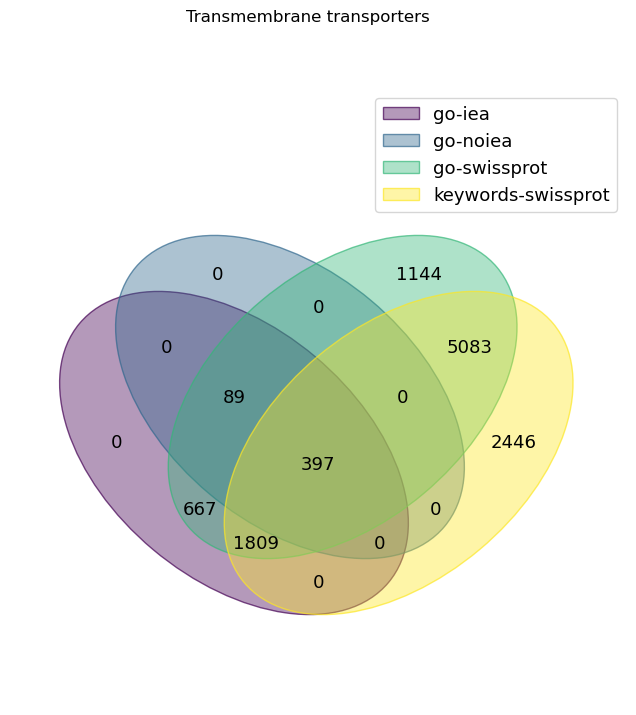

In [43]:
venn(
    {
        "go-iea": go_iea_transmembranetransport,
        "go-noiea": go_noiea_transmembranetransport,
        "go-swissprot": go_swissprot_transmembranetransport,
        "keywords-swissprot": keywords_transmembranetransport,
    }
)
plt.suptitle("Transmembrane transporters")
plt.show()


#### Amino-acid transporters

Again the same picture: No benefit in using the official GO datasets, uniprot data contains everything already.

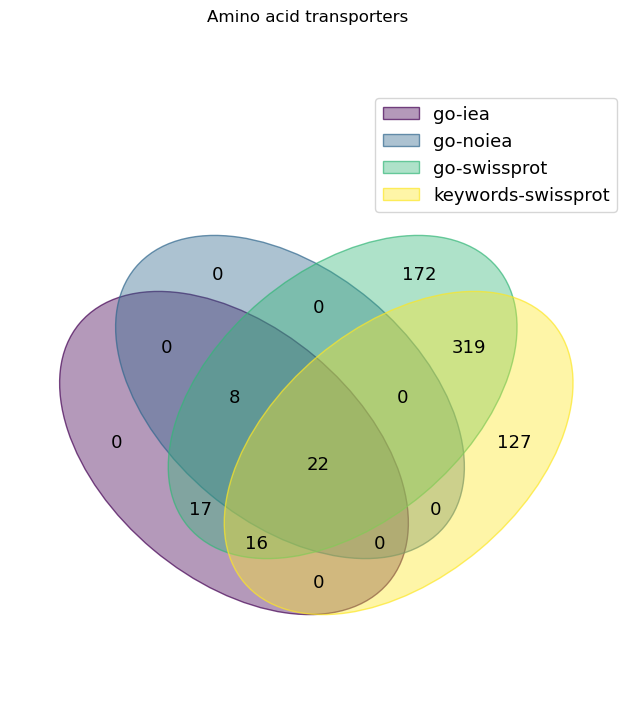

In [44]:
venn(
    {
        "go-iea": go_iea_amino,
        "go-noiea": go_noiea_amino,
        "go-swissprot": go_swissprot_amino,
        "keywords-swissprot": keywords_amino,
    }
)
plt.suptitle("Amino acid transporters")
plt.show()


#### Carbohydrate Transporters


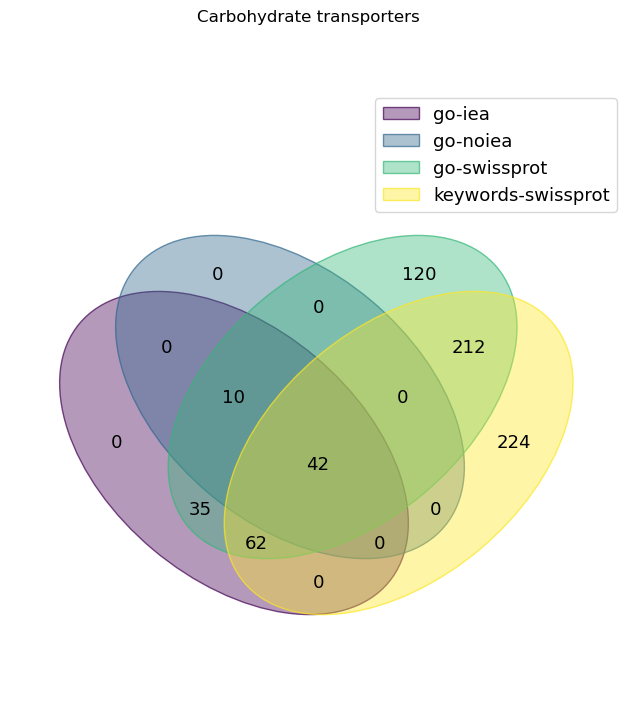

In [45]:
venn(
    {
        "go-iea": go_iea_carbo,
        "go-noiea": go_noiea_carbo,
        "go-swissprot": go_swissprot_carbo,
        "keywords-swissprot": keywords_carbo,
    }
)
plt.suptitle("Carbohydrate transporters")
plt.show()


#### Sugar


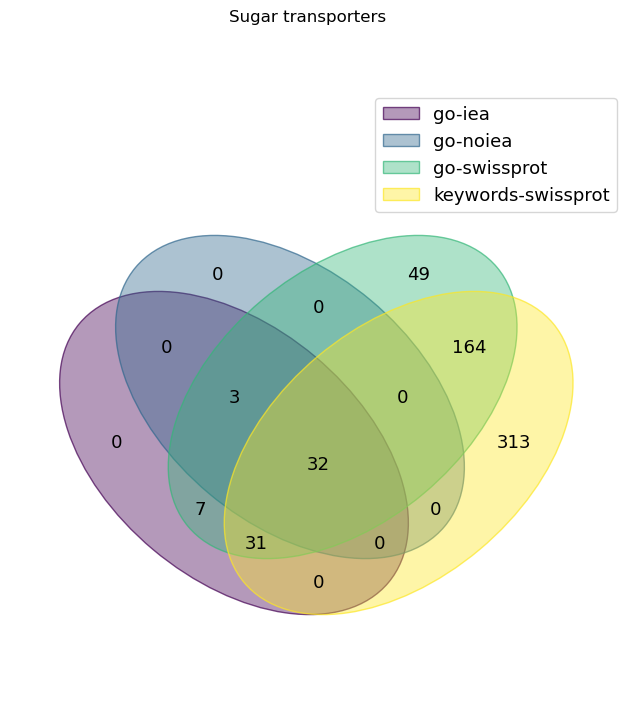

In [46]:
venn(
    {
        "go-iea": go_iea_sugar,
        "go-noiea": go_noiea_sugar,
        "go-swissprot": go_swissprot_sugar,
        "keywords-swissprot": keywords_sugar,
    }
)
plt.suptitle("Sugar transporters")
plt.show()


Maybe we should sample some of the proteins that do not have GO terms. Are they outliers, like proteins that are only associated with Sugar transport but do not carry it out?

Here are the keyword-only Sugar transporters:

In [47]:
# proteins_only_keyword_sugar = (
#     (keywords_sugar - go_swissprot_sugar) - go_iea_sugar
# ) - go_noiea_sugar

# for protein_name in df_swissprot.loc[proteins_only_keyword_sugar].protein_names:
#     print(protein_name)


In this sample, we do find many proteins that are actual sugar transporters, so it's not all outliers.

However, there are also components of complexes, as well as upstream proteins like sugar sensors that regulate sugar transporter expression.

There is also a number of "probable tranporters". 

Using keywords does give us more samples, but the problem is that the Sugar transport keyword is a Biological Process keyword, and also contains upstream and downstream proteins. Using the Transmembrane keyword filters out most of the wrong samples, but not all of them.

#### Ion transporters

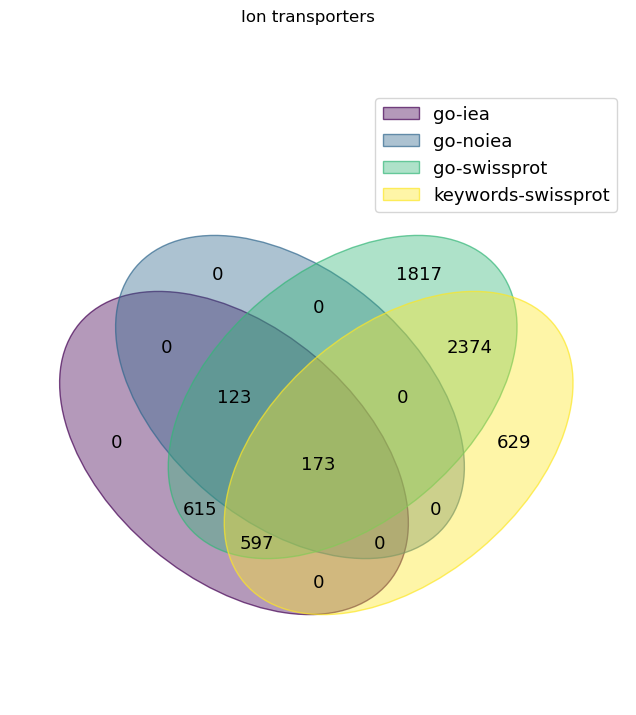

In [48]:
venn(
    {
        "go-iea": go_iea_ion,
        "go-noiea": go_noiea_ion,
        "go-swissprot": go_swissprot_ion,
        "keywords-swissprot": keywords_ion,
    }
)
plt.suptitle("Ion transporters")
plt.show()


GO adds 1808 ion transmembrane transporters! The specific ions are known for most of them.

## How many proteins have TCDB annotations?

In [49]:
tcdb_swissprot = set(df_swissprot[~df_swissprot.tcdb_id.isnull()].index.tolist())


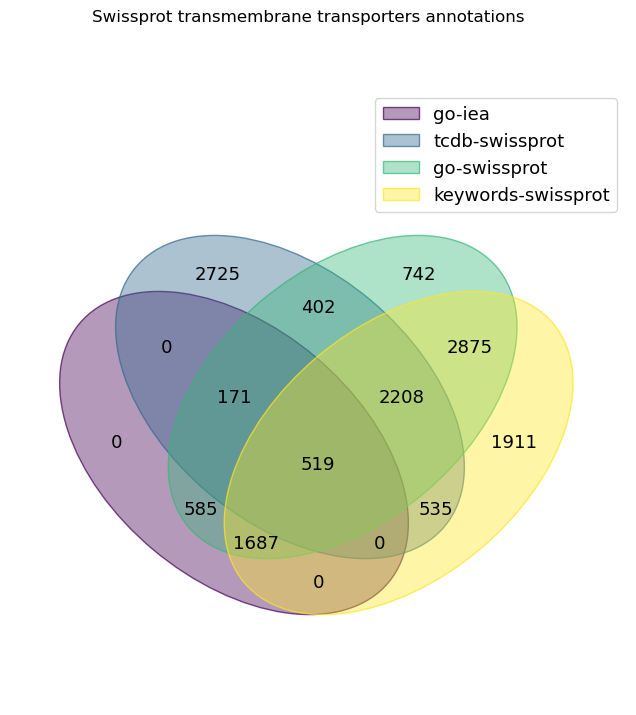

In [50]:
venn(
    {
        "go-iea": go_iea_transmembranetransport,
        "tcdb-swissprot": tcdb_swissprot,
        "go-swissprot": go_swissprot_transmembranetransport,
        "keywords-swissprot": keywords_transmembranetransport,
    }
)
plt.suptitle("Swissprot transmembrane transporters annotations")
plt.show()


There are 2725 additional (potential) transporters in TCDB that don't have transmembrane transport GO terms or Keywords!

What TCDB classes do they belong to?

In [51]:
tcdb_transmembrane_transport_diff_set = (
    (tcdb_swissprot - go_iea_transmembranetransport)
    - go_swissprot_transmembranetransport
) - keywords_transmembranetransport

tcdb_transmembrane_transport_diff_set_tcdb_classes = df_swissprot.loc[
    list(tcdb_transmembrane_transport_diff_set)
].tcdb_id.apply(lambda x: int(x[0]))

tcdb_transmembrane_transport_diff_set_tcdb_classes.value_counts().sort_index()


1    789
2    114
3    601
4     56
5     63
8    519
9    583
Name: tcdb_id, dtype: int64

Only 114 passive transporters. 519 accessory factors to transport, 583 uncharacterized transport systems. But also 789 channels, and 601 active transporters.

Do we have accessory factors to transport in our datasets, generally speaking?

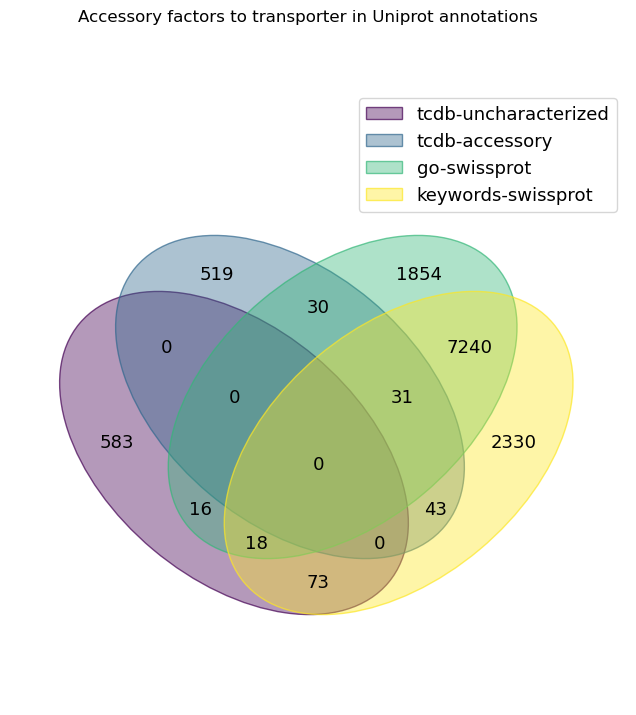

In [52]:
df_swissprot_tcdb = df_swissprot[~df_swissprot.tcdb_id.isnull()]

tcdb_accessory_factors = set(
    df_swissprot_tcdb[df_swissprot_tcdb.tcdb_id.str.startswith("8")]
    .index.unique()
    .tolist()
)
tcdb_uncharacterized = set(
    df_swissprot_tcdb[df_swissprot_tcdb.tcdb_id.str.startswith("9")]
    .index.unique()
    .tolist()
)

venn(
    {
        "tcdb-uncharacterized": tcdb_uncharacterized,
        "tcdb-accessory": tcdb_accessory_factors,
        "go-swissprot": go_swissprot_transmembranetransport,
        "keywords-swissprot": keywords_transmembranetransport,
    }
)
plt.suptitle("Accessory factors to transporter in Uniprot annotations")
plt.show()


Yes, there are 30+31+43 transmembrane transport proteins in our GO+Keyword dataset that TCDB classifies as "Accessory factors to transport". We should probably remove those from the dataset.

## ChEBI substrate annotations from TCDB

Transporters from TCDB are also annotated with substrates and ChEBI identifiers. It would be interesting to see how many proteins have more or less abstract/concrete chebi classes.

TCDB also contains accessory factors to transport, as well as membrane proteins that act upstream of substrate transport. We should take a close look at the additional data before integrating it into the training dataset.

Obviously, these additional TCDB transporters have neither GO nor Uniprot annotations for their substrates, so we can't tell the substrate that way. What happens when we filter with ChEBI classes? From the Chebi Ontology, we can get all descendants of a molecule, that could be useful to create substrate classes.

### Reading ChEBI data

In [53]:
from subpred.dataset import get_tcdb_substrates
from subpred.chebi import ChebiOntology

chebi = ChebiOntology("../data/raw/ontologies/chebi.owl")
df_chebi_sp = get_tcdb_substrates(df_swissprot)
df_chebi_sp.head()


,Uniprot,tcdb_id,chebi_id,chebi_term
0,A6NI61,1.N.2.1.1,CHEBI:25367,molecule
1,A6NKB5,9.A.80.1.1,CHEBI:24636,proton
2,O00168,1.A.27.1.8,CHEBI:22563,anion
3,O00337,2.A.41.2.3,CHEBI:9175,sodium(1+)
4,O00337,2.A.41.2.3,CHEBI:9893,uridine


### Sugar transporters

Can using TCDB+Chebi increase the number of sugar transporters in our dataset?

Interesting classes:

- CHEBI:16646 - carbohydrate
    - CHEBI:50699 oligosaccharide
    - CHEBI:18154 polysaccharide
    - CHEBI:35381 monosaccharide

All children of Carbohydrate:

In [62]:
sorted(
    [
        chebi.get_label(term)
        for term in chebi.get_children(chebi.get_identifier("carbohydrate"))
    ]
)


['D-apiofuranose',
 'alditol',
 'apulose',
 'carbohydrate acid',
 'deoxy sugar',
 'monosaccharide',
 'oligosaccharide',
 'polygalacturonide',
 'polysaccharide']

There are 70 TCDB proteins annotated with a type of carbohydrate, 38 of which are monosaccharides:

In [55]:
carbohydrates = chebi.get_descendants(chebi.get_identifier("carbohydrate"))
oligosaccharides = chebi.get_descendants(chebi.get_identifier("oligosaccharide"))
polysaccharides = chebi.get_descendants(chebi.get_identifier("polysaccharide"))
monosaccharides = chebi.get_descendants(chebi.get_identifier("monosaccharide"))

for name, chebi_set in zip(
    ["carbohydrate", "oligosaccharide", "polysaccharide", "monosaccharide"],
    [carbohydrates, oligosaccharides, polysaccharides, monosaccharides],
):
    df_chebi_sp_subset = df_chebi_sp[df_chebi_sp.chebi_id.isin(chebi_set)]
    print(name + " transporters:", df_chebi_sp_subset.Uniprot.unique().shape[0])


carbohydrate transporters: 70
oligosaccharide transporters: 20
polysaccharide transporters: 3
monosaccharide transporters: 38


Now let's look at the overlap with Swissprot Keywords and GO terms:

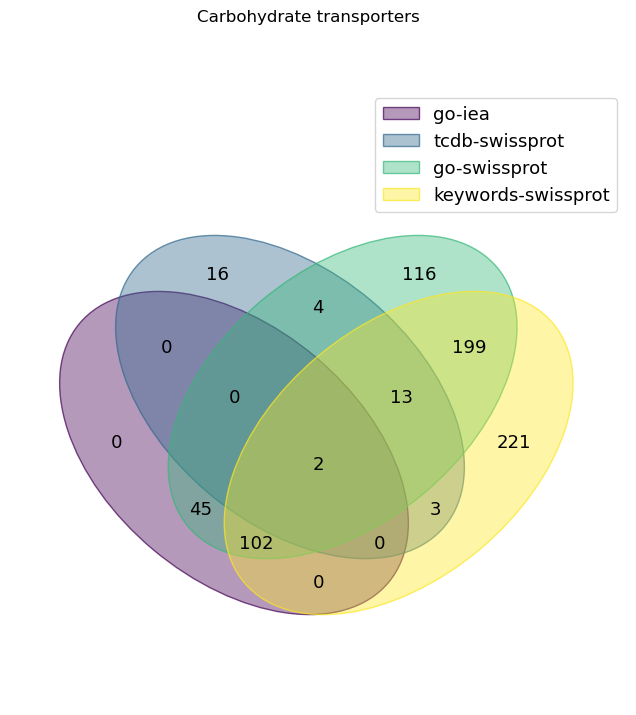

In [56]:
tcdb_carbo = set(
    df_chebi_sp[df_chebi_sp.chebi_id.isin(chebi_set)].Uniprot.unique().tolist()
)
venn(
    {
        "go-iea": go_iea_carbo,
        "tcdb-swissprot": tcdb_carbo,
        "go-swissprot": go_swissprot_carbo,
        "keywords-swissprot": keywords_carbo,
    }
)
plt.suptitle("Carbohydrate transporters")
plt.show()


There are 16 additional carbohydrate transporters in TCDB! What kind of carbohydrate to they transport?

In [57]:
df_chebi_sp_carbo_diff = df_chebi_sp[
    df_chebi_sp.Uniprot.isin((tcdb_carbo - keywords_carbo) - go_swissprot_carbo)
]

for name, chebi_set in zip(
    ["carbohydrate", "oligosaccharide", "polysaccharide", "monosaccharide"],
    [carbohydrates, oligosaccharides, polysaccharides, monosaccharides],
):
    df_chebi_sp_subset = df_chebi_sp_carbo_diff[
        df_chebi_sp_carbo_diff.chebi_id.isin(chebi_set)
    ]
    print(name, "transporters:", df_chebi_sp_subset.Uniprot.unique().shape[0])


carbohydrate transporters: 16
oligosaccharide transporters: 0
polysaccharide transporters: 0
monosaccharide transporters: 16


16 additional Monosaccharide transporters. How about other substrates?

#### Amino acid

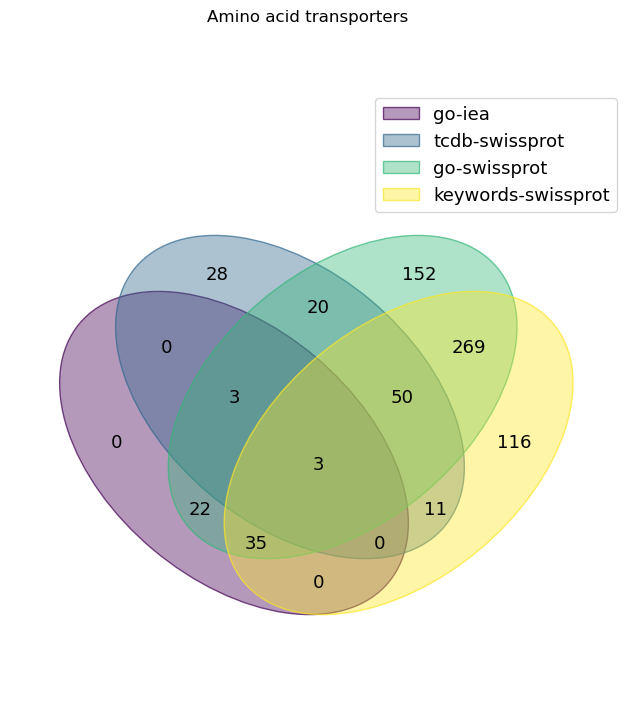

In [58]:
amino_acids = chebi.get_descendants(chebi.get_identifier("amino acid"))

tcdb_amino = set(
    df_chebi_sp[df_chebi_sp.chebi_id.isin(amino_acids)].Uniprot.unique().tolist()
)

venn(
    {
        "go-iea": go_iea_amino,
        "tcdb-swissprot": tcdb_amino,
        "go-swissprot": go_swissprot_amino,
        "keywords-swissprot": keywords_amino,
    }
)
plt.suptitle("Amino acid transporters")
plt.show()


28 additional amino acid transporters. What are the individual amino acids?

In [59]:
df_chebi_sp[df_chebi_sp.Uniprot.isin(tcdb_amino)].chebi_term.value_counts()


histidine                  29
lysine                     28
arginine                   26
proline                    17
sodium(1+)                 11
                           ..
3',5'-cyclic AMP            1
methotrexate                1
quinidine                   1
2,4-diaminobutyric acid     1
D-alanine                   1
Name: chebi_term, Length: 137, dtype: int64

The actual amino acid seems to be known for most of them. There are 137 types of amino acid being transported in total.

#### Ion

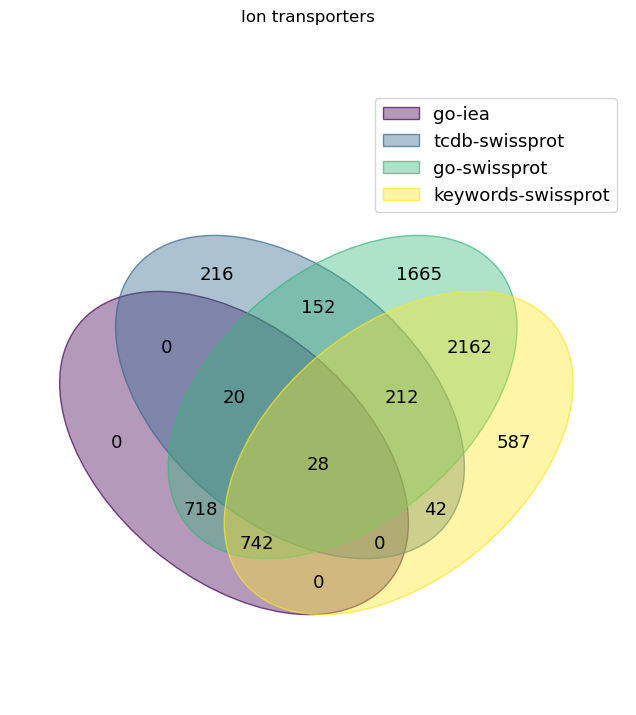

In [60]:
ions = chebi.get_descendants(chebi.get_identifier("ion"))

tcdb_ion = set(df_chebi_sp[df_chebi_sp.chebi_id.isin(ions)].Uniprot.unique().tolist())

venn(
    {
        "go-iea": go_iea_ion,
        "tcdb-swissprot": tcdb_ion,
        "go-swissprot": go_swissprot_ion,
        "keywords-swissprot": keywords_ion,
    }
)
plt.suptitle("Ion transporters")
plt.show()


216 additional Ion transporters. What kinds of ions? Here are the child ChEBI terms of Ion:

In [63]:
ion_children = chebi.get_children(chebi.get_identifier("ion"))

tcdb_ion_diff = ((tcdb_ion - go_iea_ion) - go_swissprot_ion) - keywords_ion
df_chebi_sp_ion_diff = df_chebi_sp[df_chebi_sp.Uniprot.isin(tcdb_ion_diff)]

chebi_to_count = dict()
for ion_child in ion_children:
    df_chebi_sp_ion_diff_subset = df_chebi_sp_ion_diff[
        df_chebi_sp_ion_diff.chebi_id.isin(chebi.get_descendants(ion_child))
    ]

    chebi_to_count[chebi.get_label(ion_child)] = df_chebi_sp_ion_diff_subset.Uniprot.unique().shape[0]

for label, count in sorted(chebi_to_count.items()):
    print(label, count)

anion 98
cation 69
inorganic ion 68
monoatomic ion 47
organic ion 92
polyatomic ion 87
radical ion 0
silicon(2+) 0
titanium(3+) 0


87 polyatomic ions, they should probably be a different category.

## Concusions

- Combining our keywords with GO terms from Uniprot can increase sizes of substrate classes by a good amount
- GO or Keyword dataset on their own also have good number of substrates
- Using the GO annotations from the official GO website does not give us additional data
- GO and Keyword datasets still contain "accessory factors to transport".
- Chebi annotations from TCDB can add additional samples to the substrate classes, when querying the chebi ontology for all descendant molecules.

## Up next:

- Test what happens when using TrEMBL data as well
    - Or Uniref100, to eliminate identical proteins from the dataset and only keep those with the best annotation score.
- Cluster individual datasets (GO, keywords), then find the most fitting GO term/Keyword for each cluster. That way, we can create optimal substrate classes.